<a href="https://colab.research.google.com/github/GenaroHacker/creating_chord_collection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#@title Set Up
!git clone https://github.com/GenaroHacker/write_imports.git
from write_imports.write_imports import write_imports

!git clone https://github.com/GenaroHacker/creating_chord_collection.git


from creating_chord_collection.collection.resources.scales import scales
from creating_chord_collection.collection.resources.transposable_figures import transposable_figures



In [2]:



# Delete this line to see the new imports
%%capture



#@title Import Statements
#Modules: ['creating_chord_collection', 'write_imports']




from creating_chord_collection.builder.director import Director

from creating_chord_collection.builder.builders import AbstractBuilder
from creating_chord_collection.builder.builders import ShortBuilder
from creating_chord_collection.builder.builders import LongBuilder

from creating_chord_collection.collection.chord import GuitarChord

from creating_chord_collection.collection.collection import ChordCollection



from write_imports.write_imports import write_imports

from write_imports.LearningPython.BasicExamples.intro_functions import print_hello_world





print(write_imports([]))






In [3]:
# @title Collection



# Example usage
chord_collection = ChordCollection()
chord_collection.load('/content/creating_chord_collection/collection/resources/chord_collection.db')

chord = chord_collection.chords[6]
print(chord)
chord.transpose(1)
print(chord)
chord_collection.save('new_chord_collection.db')
print(f"Collection Size: {len(chord_collection.chords)}")
chord_collection.extend_barre_chords()
print(f"Collection Size: {len(chord_collection.chords)}")

whitelist = {
     "root": ["C", "F", "G"],
     "chord_type": ["", "m", "dim"],
     "open": [False],
     "starting_fret": [1, 2, 5, 9],
     "include_string": [1, 2],
     "inversion": [1, 2, 3, None],
     "scale": [("C", scales["ionian"])]
 }

filtered_chords = chord_collection.only(whitelist)
print(f"Remaining after whitelist filter: {len(filtered_chords)}")

blacklist = whitelist
filtered_chords = chord_collection.filter_out(blacklist)
print(f"Remaining after blacklist filter: {len(filtered_chords)}")

tonality = chord_collection.get_tonality("B", scales["aeolian"], amplitude=3, rank=2)
print(f"Chords in tonality: {len(tonality)}")


('A', 'm', finger_ascending=[0, 1, 2, 2, 0, None], starting_fret=1)
('A#', 'm', finger_ascending=[1, 2, 3, 3, 1, None], starting_fret=1)
Collection Size: 132
Collection Size: 328
Remaining after whitelist filter: 1
Remaining after blacklist filter: 327
Chords in tonality: 10


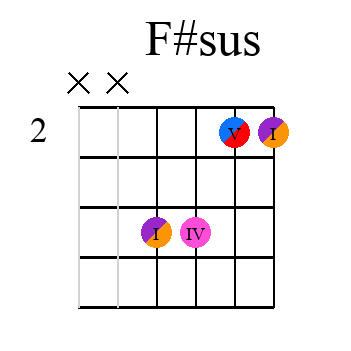

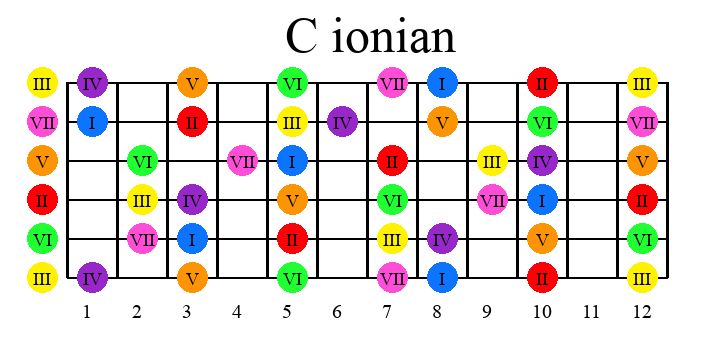

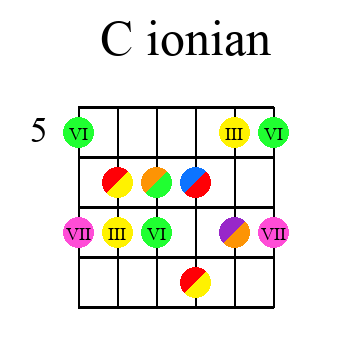

5


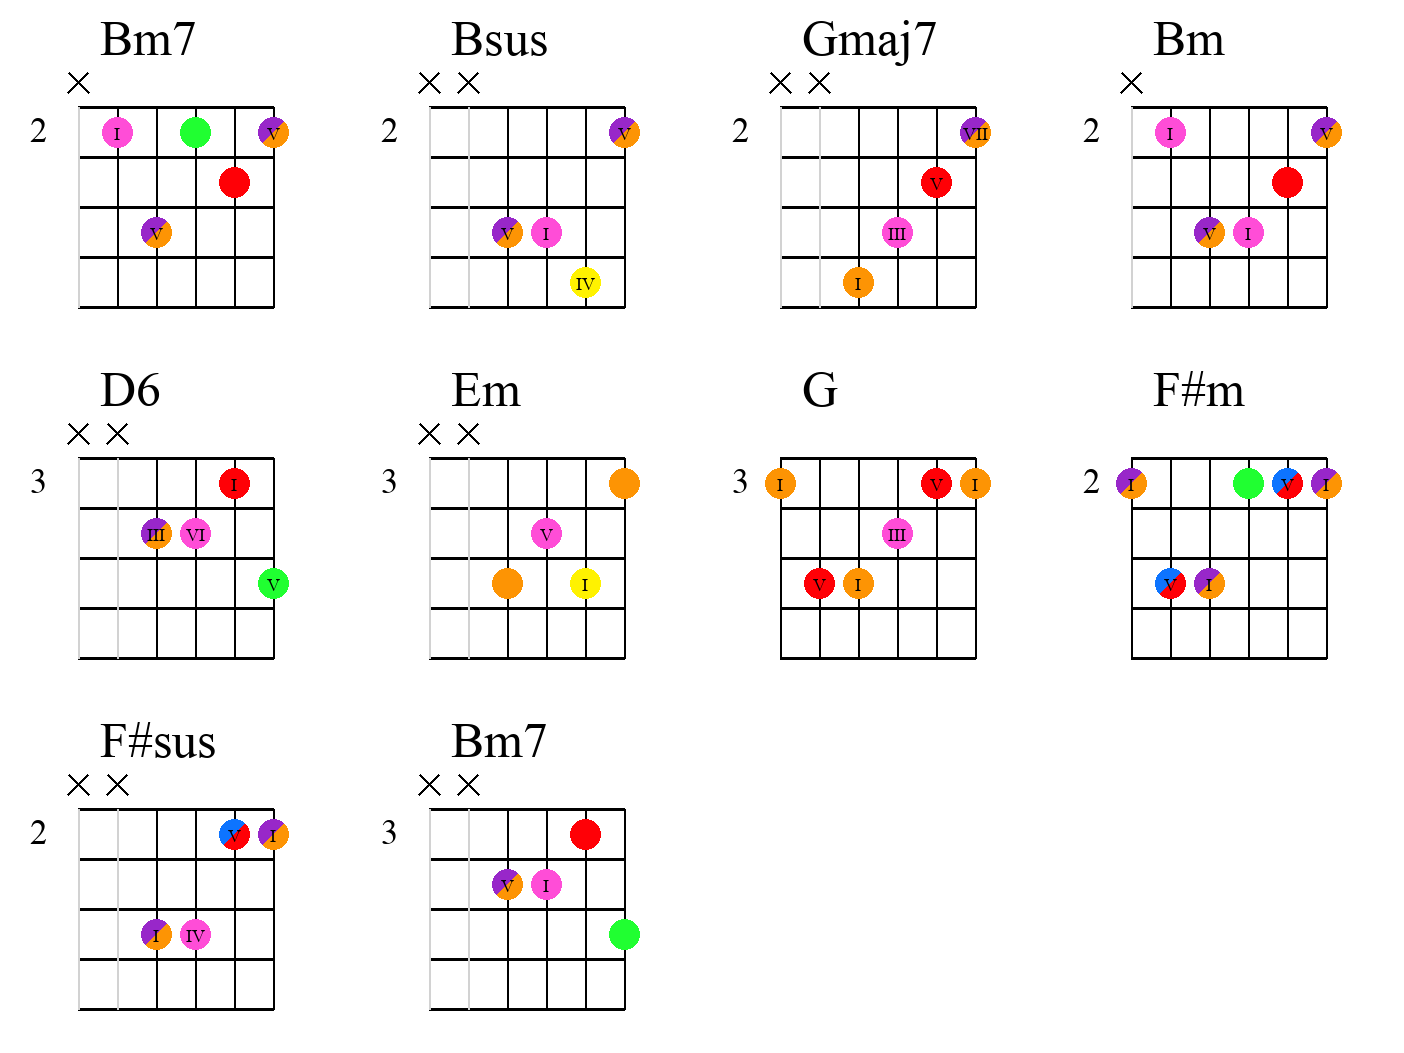

In [4]:
# @title Execution
# Example usage for a chord with LongBuilder
chord = tonality[8]


# Repeat the process with ShortChordBuilder
builder = ShortBuilder()
director = Director(builder)
director.build_chord(chord)
director.display_image()  # Directly display the image

# Define the scale as a list of integers
selected_scale = scales["ionian"]
root_note = "C"

# Example usage for a scale with LongScaleBuilder
builder = LongBuilder()
director = Director(builder)
director.build_scale(root_note, selected_scale)
director.display_image()  # Directly display the image

# Repeat the process with ShortScaleBuilder
builder = ShortBuilder()
builder.starting_fret = 3
director = Director(builder)
director.build_scale(root_note, selected_scale, starting_fret=5)
director.display_image()  # Directly display the image
print(builder.starting_fret)

director.build_multiple_chords(tonality, columns=4)
director.display_image()

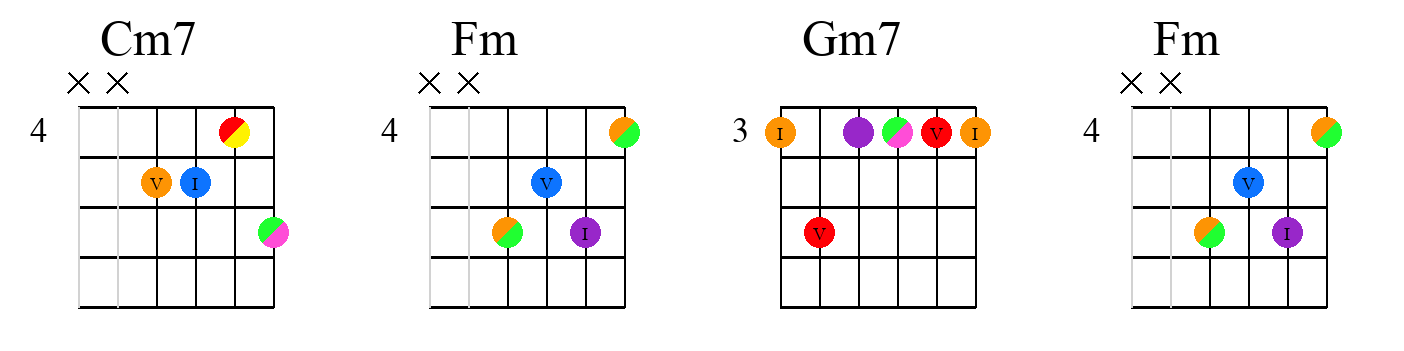

In [5]:

def get_roots(chords):
    roots = set()
    for chord in chords:
        # Accessing the root property of each chord
        roots.add(chord.root)
    return list(roots)


def ordered_note_indices_sorted(notes, root):
    chromatic_scale = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Reorder the chromatic scale to start from the root
    root_index = chromatic_scale.index(root)
    reordered_scale = chromatic_scale[root_index:] + chromatic_scale[:root_index]

    # Find the indices of the notes in the reordered scale
    indices = [reordered_scale.index(note) for note in notes]

    # Sort the indices before returning
    return sorted(indices)


def convert_chord_progressions_to_ints(chord_progressions):
    # The dictionary mapping chord names to their integer values
    chords_dict = {
        "I": 0, "ii": 1, "II": 2, "iii": 3, "III": 4,
        "IV": 5, "v": 6, "V": 7, "vi": 8, "VI": 9,
        "vii": 10, "VII": 11
    }

    # Converting each chord in the progressions to its integer value
    int_progressions = []
    for progression in chord_progressions:
        int_progression = [chords_dict[chord] for chord in progression]
        int_progressions.append(int_progression)

    return int_progressions


def filter_lists(reference_list, list_of_lists):
    # Filter out lists that contain elements not in the reference list
    filtered_lists = [sublist for sublist in list_of_lists if all(item in reference_list for item in sublist)]

    # Check if the length of filtered_lists is less than 3
    while len(filtered_lists) < 3:
        # Generate a new list of 4 random items from the reference list
        new_list = random.choices(reference_list, k=4)
        filtered_lists.append(new_list)

    return filtered_lists

def reorder_scale(root, chromatic_scale):
    """Reorder the chromatic scale starting from the given root."""
    root_index = chromatic_scale.index(root)
    return chromatic_scale[root_index:] + chromatic_scale[:root_index]

def translate_to_notes(root, list_of_lists):
    """Translate lists of indexes to their corresponding musical notes based on the chromatic scale starting from the given root."""
    # The original chromatic scale
    chromatic_scale = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Reorder the chromatic scale to start from the root
    reordered_scale = reorder_scale(root, chromatic_scale)

    # Translate each index in the list of lists to its corresponding note
    translated_lists = []
    for lst in list_of_lists:
        translated_list = [reordered_scale[index] for index in lst]
        translated_lists.append(translated_list)

    return translated_lists

import random

def pick_random_chord_with_root(chord_collection, root):
    """
    Picks a random chord with the specified root from a ChordCollection.

    :param chord_collection: ChordCollection object
    :param root: Root note of the chord
    :return: Random chord with the specified root
    """
    # Define the filter for the root note
    filter_criteria = {
        "root": [root]
    }

    # Use the `only` method to filter chords by the root note
    filtered_chords = chord_collection.only(filter_criteria)

    if not filtered_chords:
        raise ValueError(f"No chords found with root '{root}'")

    # Pick and return a random chord from the filtered list
    return random.choice(filtered_chords)


def pick_chords(list_of_lists, chord_collection):
    """
    Picks a random list of root notes from the given list of lists,
    then for each root note, picks a random chord from the chord collection.

    :param list_of_lists: List of lists of root notes.
    :param chord_collection: A chord collection object.
    :return: List of chords corresponding to the randomly picked root notes.
    """
    # Randomly pick one list of root notes
    chosen_list = random.choice(list_of_lists)

    # Update each root note with a random chord
    updated_chords = [pick_random_chord_with_root(chord_collection, root) for root in chosen_list]

    return updated_chords


# Example chord progressions
chord_progressions = [
    ["I", "V", "vi", "IV"],  # I–V–vi–IV
    ["ii", "V", "I", "IV"],  # ii–V–I–IV
    ["I", "IV", "V", "IV"],  # I–IV–V–IV
    ["vi", "IV", "I", "V"],  # vi–IV–I–V
    ["I", "vi", "IV", "V"]   # I–vi–IV–V
]






root = 'C'

# Example usage
chord_collection = ChordCollection()
chord_collection.load('/content/creating_chord_collection/collection/resources/chord_collection.db')
chord_collection.extend_barre_chords()
tonality = chord_collection.get_tonality(root, scales["aeolian"], amplitude=3, rank=2)
chord_collection.chords = tonality


# Get the unique roots from the chord collection
unique_roots = get_roots(tonality)
available_chords = ordered_note_indices_sorted(unique_roots, root)
# Converting the chord progressions
converted_progressions = convert_chord_progressions_to_ints(chord_progressions)
filtered_result = filter_lists(available_chords, converted_progressions)
translated_lists = translate_to_notes(root, filtered_result)

result = pick_chords(translated_lists, chord_collection)

director.build_multiple_chords(result, columns=4)
director.display_image()